<a href="https://colab.research.google.com/github/clemencia/ML4PPGF_UERJ/blob/master/ATLAS_Htautau_bdt_tutorial_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boosted decision tree tutorial

***
## Introduction:
#### Boosted decision tree code:
We'll use the python API for the [XGBoost (eXtreme Gradient Boosting) library](https://github.com/dmlc/xgboost).

#### Data:
[Atlas](https://home.cern/about/experiments/atlas) hosted a [Kaggle](https://www.kaggle.com/) competition for identifying Higgs to tau tau events, [the Higgs Boson Machine Learning Challenge](https://www.kaggle.com/c/higgs-boson/data). The training data for this event contains 250,000 labeled, simulated Atlas events in csv format described [here](https://www.kaggle.com/c/higgs-boson/data) and [here](https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf). You can download it youself, or we have a small subset (10k events) in the "data" directory in this repository that we use here.

#### Data handling:
If you don't have [pandas](http://pandas.pydata.org/), you should get pandas. It's an amazing tool for exploring data in Python.
***
#### Install XGBoost:
Assuming you have python, numpy, matplotlib, and pandas installed, you just need to install XGBoost. Detailed installation instructions are [here](https://xgboost.readthedocs.io/en/latest/build.html). If you're on Ubuntu, just do this (in your terminal):
```bash
git clone --recursive https://github.com/dmlc/xgboost
cd xgboost
make
```
***
#### Links:
A lot of this was borrowed from other sources. These sources and other good places for information about XGBoost and BDTs in general are here:

XGBoost demo: [Example of how to use XGBoost Python Module to run Kaggle Higgs competition](https://github.com/dmlc/xgboost/tree/master/demo/kaggle-higgs)

Blog post by phunther: [Winning solution of Kaggle Higgs competition: what a single model can do?](https://no2147483647.wordpress.com/2014/09/17/winning-solution-of-kaggle-higgs-competition-what-a-single-model-can-do/)

XGBoost Kaggle Higgs solution: https://github.com/hetong007/higgsml

***

## Tutorial:

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

%matplotlib inline

### The data
#### Load data:
First, load in the data and look at it. We've taken a 10k event subsample of the Kaggle training data. Then we'll put it in the right format for xgboost.

In [0]:
data = pd.read_csv('/content/training_10k.csv')

In [0]:
data.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.2,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,0.879,1.414,-999.0,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,3.776,1.414,-999.0,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,2.354,-1.285,-999.0,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,1.056,-1.385,-999.0,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


Let's see what the data looks like:

In [0]:
print('Size of data: {}'.format(data.shape))
print('Number of events: {}'.format(data.shape[0]))
print('Number of columns: {}'.format(data.shape[1]))

print ('\nList of features in dataset:')
for col in data.columns:
    print(col)

Size of data: (10000, 33)
Number of events: 10000
Number of columns: 33

List of features in dataset:
EventId
DER_mass_MMC
DER_mass_transverse_met_lep
DER_mass_vis
DER_pt_h
DER_deltaeta_jet_jet
DER_mass_jet_jet
DER_prodeta_jet_jet
DER_deltar_tau_lep
DER_pt_tot
DER_sum_pt
DER_pt_ratio_lep_tau
DER_met_phi_centrality
DER_lep_eta_centrality
PRI_tau_pt
PRI_tau_eta
PRI_tau_phi
PRI_lep_pt
PRI_lep_eta
PRI_lep_phi
PRI_met
PRI_met_phi
PRI_met_sumet
PRI_jet_num
PRI_jet_leading_pt
PRI_jet_leading_eta
PRI_jet_leading_phi
PRI_jet_subleading_pt
PRI_jet_subleading_eta
PRI_jet_subleading_phi
PRI_jet_all_pt
Weight
Label


The data set has 10,000 events with 33 columns each. It looks like the first column is an identifier, and shouldn't be used as a feature. The last two columns "Weight" and "Label", are the weights and labels from the simulation, and also shouldn't be used as features (this information is all contained in the documentation).

Now we can look at how many events are signal and background:

In [0]:
# look at column labels --- notice last one is "Label" and first is "EventId" also "Weight"
print('Number of signal events: {}'.format(len(data[data.Label == 's'])))
print('Number of background events: {}'.format(len(data[data.Label == 'b'])))
print('Fraction signal: {}'.format(len(data[data.Label == 's'])/(float)(len(data[data.Label == 's']) + len(data[data.Label == 'b']))))

Number of signal events: 3372
Number of background events: 6628
Fraction signal: 0.3372


#### Format data:
Now we should get the data into an XGBoost-friendly format. We can create DMatrix objects that will be used to train the BDT model. For now, we'll use all 30 of the features for training.

First, we'll sliceup the data into training and testing sets. Here, we take 20% for the test set, which is arbitrary.

In this file, all samples are independent and ordered randomly, so we can just grab a chunk. Check out [scikit-learn Cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) for dividing up samples in a responsible way.

We can also change the data type of the "Label" column to the pandas type "category" for easier use later.

In [0]:
data['Label'] = data.Label.astype('category')


In [0]:
data_train = data[:8000]
data_test = data[8000:]


Check to make sure we did it right:

In [0]:
print('Number of training samples: {}'.format(len(data_train)))
print('Number of testing samples: {}'.format(len(data_test)))

print('\nNumber of signal events in training set: {}'.format(len(data_train[data_train.Label == 's'])))
print('Number of background events in training set: {}'.format(len(data_train[data_train.Label == 'b'])))
print('Fraction signal: {}'.format(len(data_train[data_train.Label == 's'])/(float)(len(data_train[data_train.Label == 's']) + len(data_train[data_train.Label == 'b']))))

print(data_train.Label.cat.codes[0:10])

Number of training samples: 8000
Number of testing samples: 2000

Number of signal events in training set: 2688
Number of background events in training set: 5312
Fraction signal: 0.336
0    1
1    0
2    0
3    0
4    0
5    0
6    1
7    1
8    0
9    1
dtype: int8


The DMatrix object takes as arguments:
- data --- the features
- label --- 1/0 or true/false for binary data (we have to convert our label to bool from string s/b)
- missing --- how missing values are represented (here as -999.0)
- feature_names --- the names of all of the features (optional)

In [0]:
feature_names = data.columns[1:-2]  # we skip the first and last two columns because they are the ID, weight, and label
train = xgb.DMatrix(data=data_train[feature_names],label=data_train.Label.cat.codes,
                    missing=-999.0,feature_names=feature_names)
test = xgb.DMatrix(data=data_test[feature_names],label=data_test.Label.cat.codes,
                   missing=-999.0,feature_names=feature_names)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Check if we did it right:

In [0]:
print('Number of training samples: {}'.format(train.num_row()))
print('Number of testing samples: {}'.format(test.num_row()))



Number of training samples: 8000
Number of testing samples: 2000


### Make the model
#### Set hyperparameters:
The XGBoost hyperparameters are defined [here](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md). For a nice description of what they all mean, and tips on tuning them, see [this guide](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/).

In general, the tunable parameters in XGBoost are the ones you would see in other gradient boosting libraries. Here, they fall into three categories:
1. General parameters - Ex. :which booster to use, number of threads. I won't mess with any of these here.
2. Booster parameters - Tune the actual boosting. Ex.: learning rate. These are the ones to optimize.
3. Learning task parameters - Define the objective function and the evaluation metrics.

Here, we will use the defaults for most parameters and just set a few to see how it's done. The parameters are passed in as a dictionary or list of pairs.

Make the parameter dictionary:

In [0]:
param = {}

# Boost5er parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 8  # maximum depth of a tree
param['subsample']        = 0.5 # fraction of events to train tree on
param['colsample_bytree'] = 0.7 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]
print(param)
num_trees = 150  # number of trees to make

[('eta', 0.1), ('max_depth', 8), ('subsample', 0.5), ('colsample_bytree', 0.7), ('objective', 'binary:logistic'), ('eval_metric', 'error'), ('eval_metric', 'logloss'), ('eval_metric', 'rmse')]


First, we set the booster parameters. Again, we just chose a few here to experiment with. These are the paraters to tune to optimize your model. Generally, there is a trade off between speed and accuracy.
1. ```eta``` is the learning rate. It determines how much to change the data weights after each boosting iteration. The default is 0.3.
2. ```max_depth``` is the maximum depth of any tree. The default is 6.
3. ```subsample``` is the fraction of events used to train each new tree. These events are randomly sampled each iteration from the whole sample set. The default is 1 (use every event for each tree).
4. ```colsample_bytree``` is the fraction of features available to train each new tree. These features are randomly sampled each iteration from the whole feature set. The default is 1.

Next, we set the learning objective to ```binary:logistic```. So, we have two classes that we want to score from 0 to 1. The ```eval_metric``` parameters set what we want to monitor when doing cross validation. (We aren't doing cross validation in this example, but we really should be!) If you want to watch more than one metric, ```param``` must be a list of pairs, instead of a dict. Otherwise, we would just keep resetting the same parameter.

Last, we set thenumber of trees to 100. Usually, you would set this number high, and choose a cut off point based on the cross validation. The number of trees is the same as the number of iterations.

### Now train!

In [0]:
booster = xgb.train(param,train,num_boost_round=num_trees)

We now have a trained model. The next step is to look at it's performance and try to improve the model if we need to. We can try to improve it by improving/adding features, adding more training data, using more boosting iterations, or tuning the hyperparameters (ideally in that order).

#### Evaluate:
First, let's look at how it does on the test set:

In [0]:
print(booster.eval(test))

[0]	eval-error:0.171000	eval-logloss:0.385190	eval-rmse:0.347995


These are the evaluation metrics that we stored in the parameter set.

It's pretty hard to interpret the performance of a classifier from a few number. So, let's look at the predictions for the entire test set.

In [0]:
predictions = booster.predict(test)

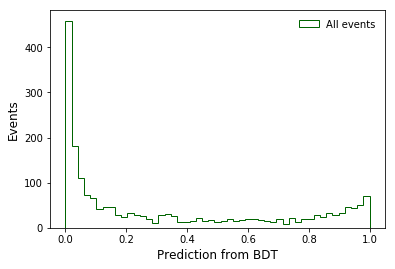

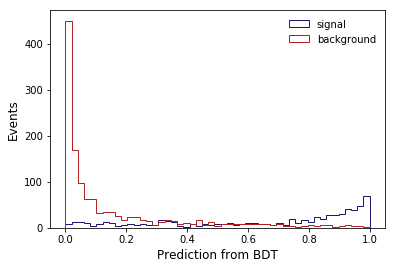

In [0]:
# plot all predictions (both signal and background)
plt.figure();
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

# plot signal and background separately
plt.figure();
plt.hist(predictions[test.get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal');
plt.hist(predictions[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


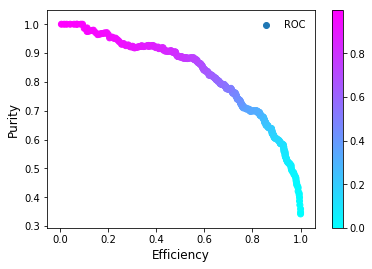

In [0]:
# choose score cuts:
cuts = np.linspace(0,1,500);
nsignal = np.zeros(len(cuts));
nbackground = np.zeros(len(cuts));
for i,cut in enumerate(cuts):
    nsignal[i] = len(np.where(predictions[test.get_label().astype(bool)] > cut)[0]);
    nbackground[i] = len(np.where(predictions[~(test.get_label().astype(bool))] > cut)[0]);
    
# plot efficiency vs. purity (ROC curve)
plt.figure();
plt.scatter(nsignal/len(data_test[data_test.Label == 's']),nsignal/(nsignal + nbackground),c=cuts,cmap="cool",label="ROC");
# make the plot readable
plt.xlabel('Efficiency',fontsize=12);
plt.ylabel('Purity',fontsize=12);
plt.colorbar()
plt.legend(frameon=False);

It's also very informative to look at the importance of each feature. The "F score" is the number of times each feature is used to split the data over all of the trees (times the weight of that tree).

There is a built-in function in the XGBoost python API to easily plot this:

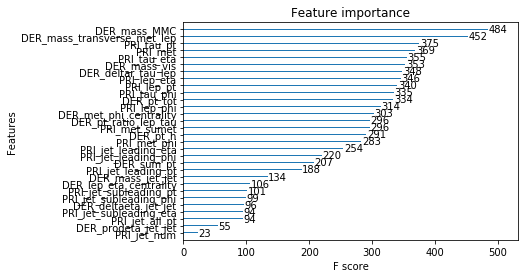

In [0]:
xgb.plot_importance(booster,grid=False);

The feature that was used the most was "```DER_mass_MMC```. (For this data the "DER" prefix is for derived variables, and "PRI" is for raw variables.)

We can plot how this feature is ditributed for the signal and background:

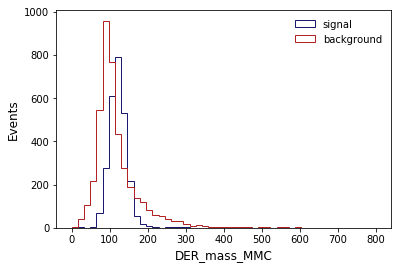

In [0]:
plt.figure();
plt.hist(data_train.DER_mass_MMC[data_train.Label == 's'],bins=np.linspace(0,800,50),
         histtype='step',color='midnightblue',label='signal');
plt.hist(data_train.DER_mass_MMC[data_train.Label == 'b'],bins=np.linspace(0,800,50),
         histtype='step',color='firebrick',label='background');

plt.xlabel('DER_mass_MMC',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

There is not a lot of discriminating power in that variable. For fun, we can plot it with the next most important feature:

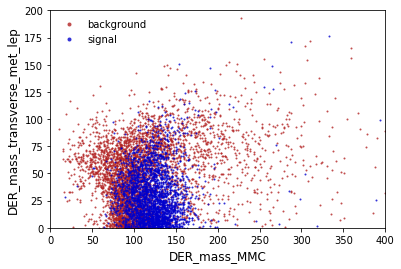

In [0]:
plt.figure();
plt.plot(data_train.DER_mass_MMC[data_train.Label == 'b'],data_train.DER_mass_transverse_met_lep[data_train.Label == 'b'],
         'o',markersize=2,color='firebrick',markeredgewidth=0,alpha=0.8,label='background');
plt.plot(data_train.DER_mass_MMC[data_train.Label == 's'],data_train.DER_mass_transverse_met_lep[data_train.Label == 's'],
         'o',markersize=2,color='mediumblue',markeredgewidth=0,alpha=0.8,label='signal');

plt.xlim(0,400);
plt.ylim(0,200);
plt.xlabel('DER_mass_MMC',fontsize=12);
plt.ylabel('DER_mass_transverse_met_lep',fontsize=12);
plt.legend(frameon=False,numpoints=1,markerscale=2);